# Apply enrichment scoring as feature selection

## 1. Set up the notebook

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from umap import UMAP
from tfidf import TFIDF
from scipy.io import mmread
from scipy.sparse import csr_matrix 
from sklearn.decomposition import TruncatedSVD
from SEMITONES.support_funcs import load_sparse_h5, sig_dictionary
from SEMITONES.enrichment_scoring import sig_interval

In [2]:
os.chdir("../data/processed/")

In [3]:
legend_order = ["HSC", "MPP",
         "CMP", "MEP", "ERYTHROCYTE",
         "CMP", "GMP", "GP", "BASO",
         "MP", "IMMATURE MONO_CLAS", "MONO_CLAS", "MONO_INT", "MONO_NONCLAS",
         "CLP", "PRE_B", "B_TRANSITIONAL", "B_NAIVE", "B_MEMORY", "PLASMABLAST", "PLASMA",
         "CD4_NAIVE", "CD4_MEMORY", "CD4_TH17",
         "CD8_NAIVE", "CD8_MAIT", "CD8_CENTRAL_MEMORY", "CD8_EFFECTOR_MEMORY",
         "CD8_TERM_EFFECT", "NK", "mDC", "pDC"]

We import the annotations and make the visualizations

In [4]:
annots = pd.read_csv("greenleaf_scRNA_gui_rbf_8e1_annotations.csv", sep="\t")
colors = list(annots.COLOUR)
labels = annots.ANNOT
ids = [int(i) for i in annots.ID]

coldict = dict(zip(annots.ANNOT, annots.COLOUR))
legend = {k: coldict[k] for k in legend_order}
marker = [plt.Line2D([0,0], [0,0], color=c, marker="o", ls="")
          for c in legend.values()]

In [5]:
markers = {"HSC": "AVP",
           "MPP": "SPINK2",
           "CMP": "GATA2",
           "MEP": "HBD",
           "ERYTHROCYTE": "HBB",
           "GMP": "MPO",
           "GP": "CTSG",
           "BASO": "HDC",
           "MP": "RETN",
           "IMMATURE MONO_CLAS": "S100A9",
           "MONO_CLAS": "VCAN",
           "MONO_INT": "LGALS2",
           "MONO_NONCLAS": "C1QA",
           "CLP": "AKAP12", 
           "PRE_B": "VPREB1", 
           "B_TRANSITIONAL": "DTX1",
           "B_NAIVE": "TCL1A",
           "B_MEMORY": "MS4A1",
           "PLASMABLAST": "IGLL5",
           "PLASMA": "TNFRSF17",
           "CD4_NAIVE": "LEF1",
           "CD4_MEMORY": "LTB",
           "CD4_TH17": "TNFRSF4",
           "T_REG": "DUSP4",
           "CD8_NAIVE": "NELL2",
           "CD8_MAIT": "SLC4A10",
           "CD8_CENTRAL_MEMORY": "CCL5",
           "CD8_EFFECTOR_MEMORY": "DUSP2",
           "CD8_TERM_EFFECT": "NKG7",
           "NK": "GNLY",
           "pDC": "LILRA4",
           "mDC": "ENHO"}

## 3. Define the normalization function for HVG selection
We take this from Scanpy Copyright (c) 2017 F. Alexander Wolf, P. Angerer, Theis Lab

In [6]:
def _normalized_dispersion(means, variances, n_bins=100):
    # as taken from Scanpy preprocessing _highly_variable_genes.py
    # Copyright (c) 2017 F. Alexander Wolf, P. Angerer, Theis Lab
    means[means == 0] = 1e-12  # make sure there are no zero-divisions

    dispersions = variances / means
    dispersions[dispersions == 0] = np.nan
    dispersions = np.log(dispersions)  # log-transform
    
    means = np.log1p(means)  # log-transform

    df = pd.DataFrame()  # store in df
    df["means"] = means
    df["dispersions"] = dispersions
    # normalize
    df["means_bins"] = pd.cut(df["means"], bins=n_bins)  # bin the means
    disp_grouped = df.groupby("means_bins")["dispersions"]  # group by bin
    disp_means_bin = disp_grouped.mean()  # get mean per bin
    disp_std_bin = disp_grouped.std(ddof=1)  # get sample std per group
    
    # make sure if std is np.nan, and there is only one gene per bin, 
    o_g_p_b = disp_std_bin.isnull()  # one gene per bin
    disp_std_bin[o_g_p_b.values] = disp_means_bin[o_g_p_b.values].values
    disp_means_bin[o_g_p_b.values] = 0
    
    df["dispersions_norm"] = (
        (df["dispersions"].values  # use values here as index differs
         - disp_means_bin[df["means_bins"].values].values
        ) / disp_std_bin[df["means_bins"].values].values
    )
    
    return df

## 4. Load data

We use the normalized, non-log transformed data for HVG selection and dimensionality reduction

In [7]:
fname = "greenleaf_scRNA_combined_norm.mtx"
X = mmread(fname)
X = csr_matrix(X)

In [8]:
with open("greenleaf_scRNA_combined_genes.txt", "r") as f:
    genes = [g.strip("\n") for g in f.readlines()]
f.close()

Import the enrichment scores calculated using the cosine distance over the top 50 PCs

In [9]:
escores = pd.read_csv("greenleaf_scRNA_escores_knn_cosineoversvd.txt",
                      sep="\t", index_col=0)

Import the null distribution for signficance testing

In [10]:
pscores = pd.read_csv("../interim/greenleaf_scRNA_pscores_knn_cosineoversvd.txt",
                      sep="\t", index_col=0)

## 2. Calculate dispersions

In [11]:
mean = np.ravel(np.log1p(X.mean(axis=0)))

e_mu = np.log1p(X.copy())
e_mu.data **= 2
e_mu = e_mu.mean(axis=0)

mu_e = np.log1p(X.copy())
mu_e = np.ravel(mu_e.mean(axis=0))
mu_e **= 2

var = np.ravel(e_mu - mu_e)
del e_mu, mu_e

disps = _normalized_dispersion(mean, var, n_bins=500)

## 3. Compare using the top 4000 genes

### a. Using escores

In [12]:
s = sig_interval(pscores, n_sds=26.9256)
s = sig_dictionary(escores, s)
topE4000 = []
for k, v in s.items():
    topE4000.extend(v)
topE4000 = list(set(topE4000))

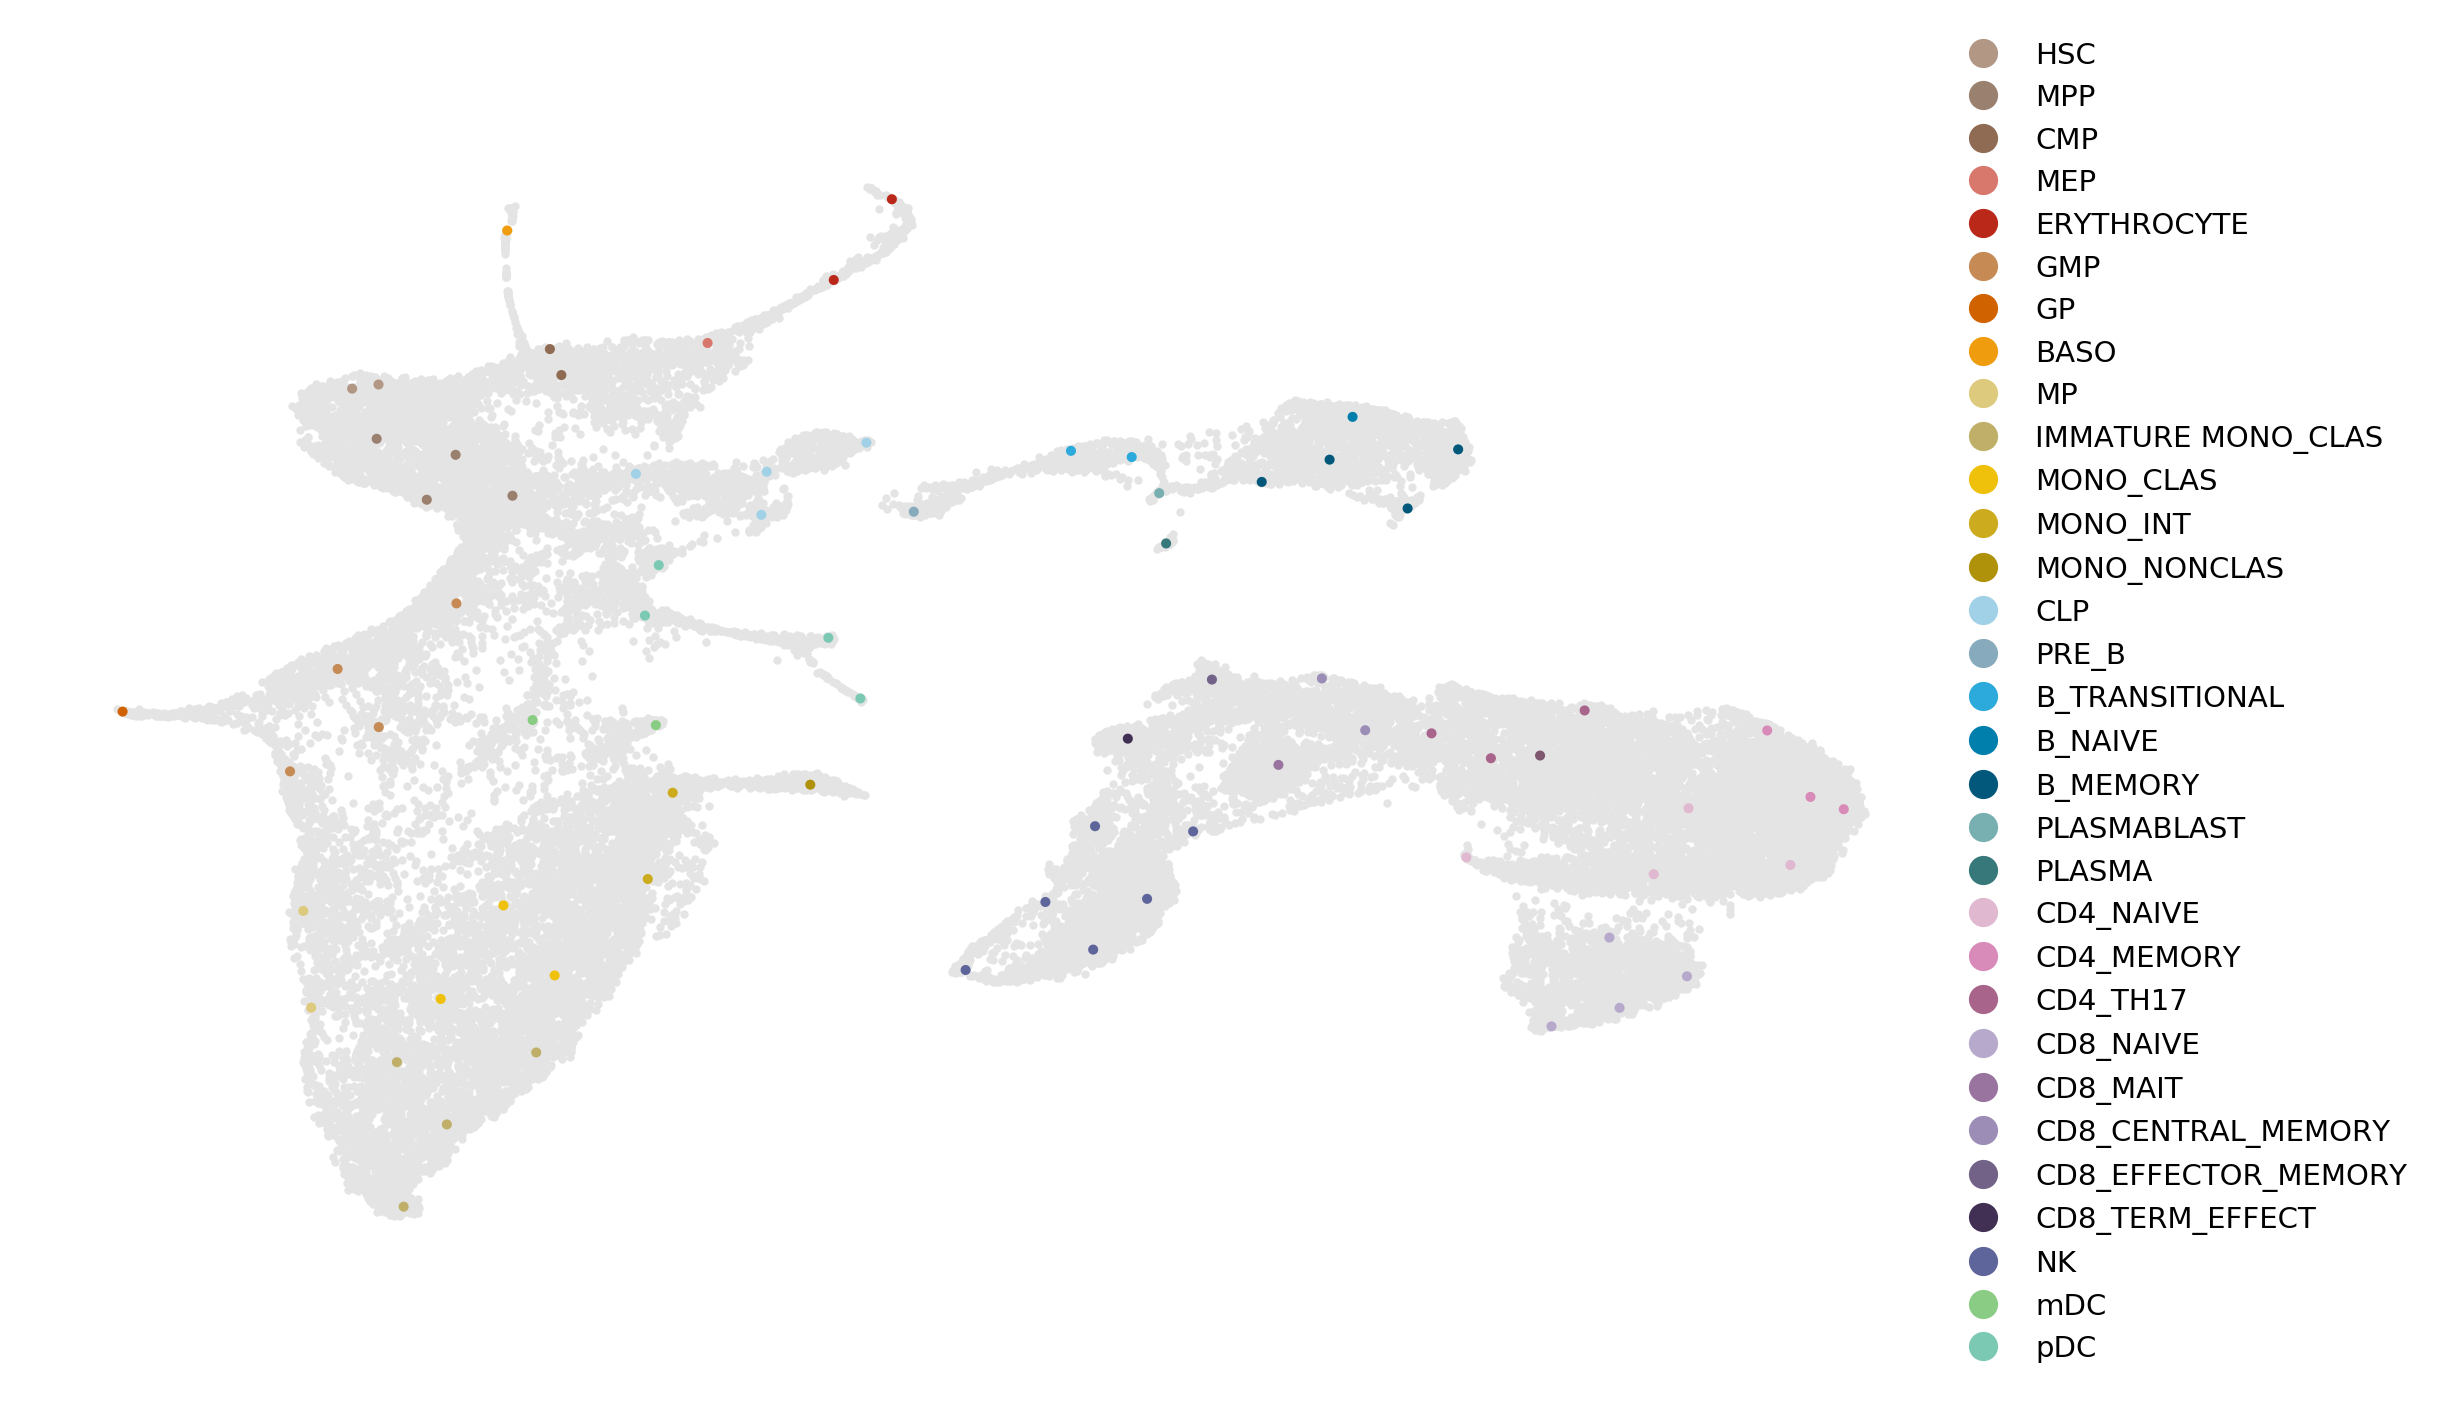

In [13]:
idxsE4000 = np.where(np.isin(genes, topE4000))[0]
X_E4000 = X[:, idxsE4000]

TFIDF_E4000 = TFIDF(X_E4000)
SVD_E4000 = TruncatedSVD(n_components=50).fit_transform(TFIDF_E4000)
UMAP_E4000 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_E4000)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_E4000[:, 0], UMAP_E4000[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_E4000[ids, 0], UMAP_E4000[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [14]:
np.save("greenleaf_scRNA_E4000_UMAP.npy", UMAP_E4000)

### c. Compare to highly variable genes

In [15]:
len(np.where(disps.dispersions_norm > 0.6244)[0])

4000

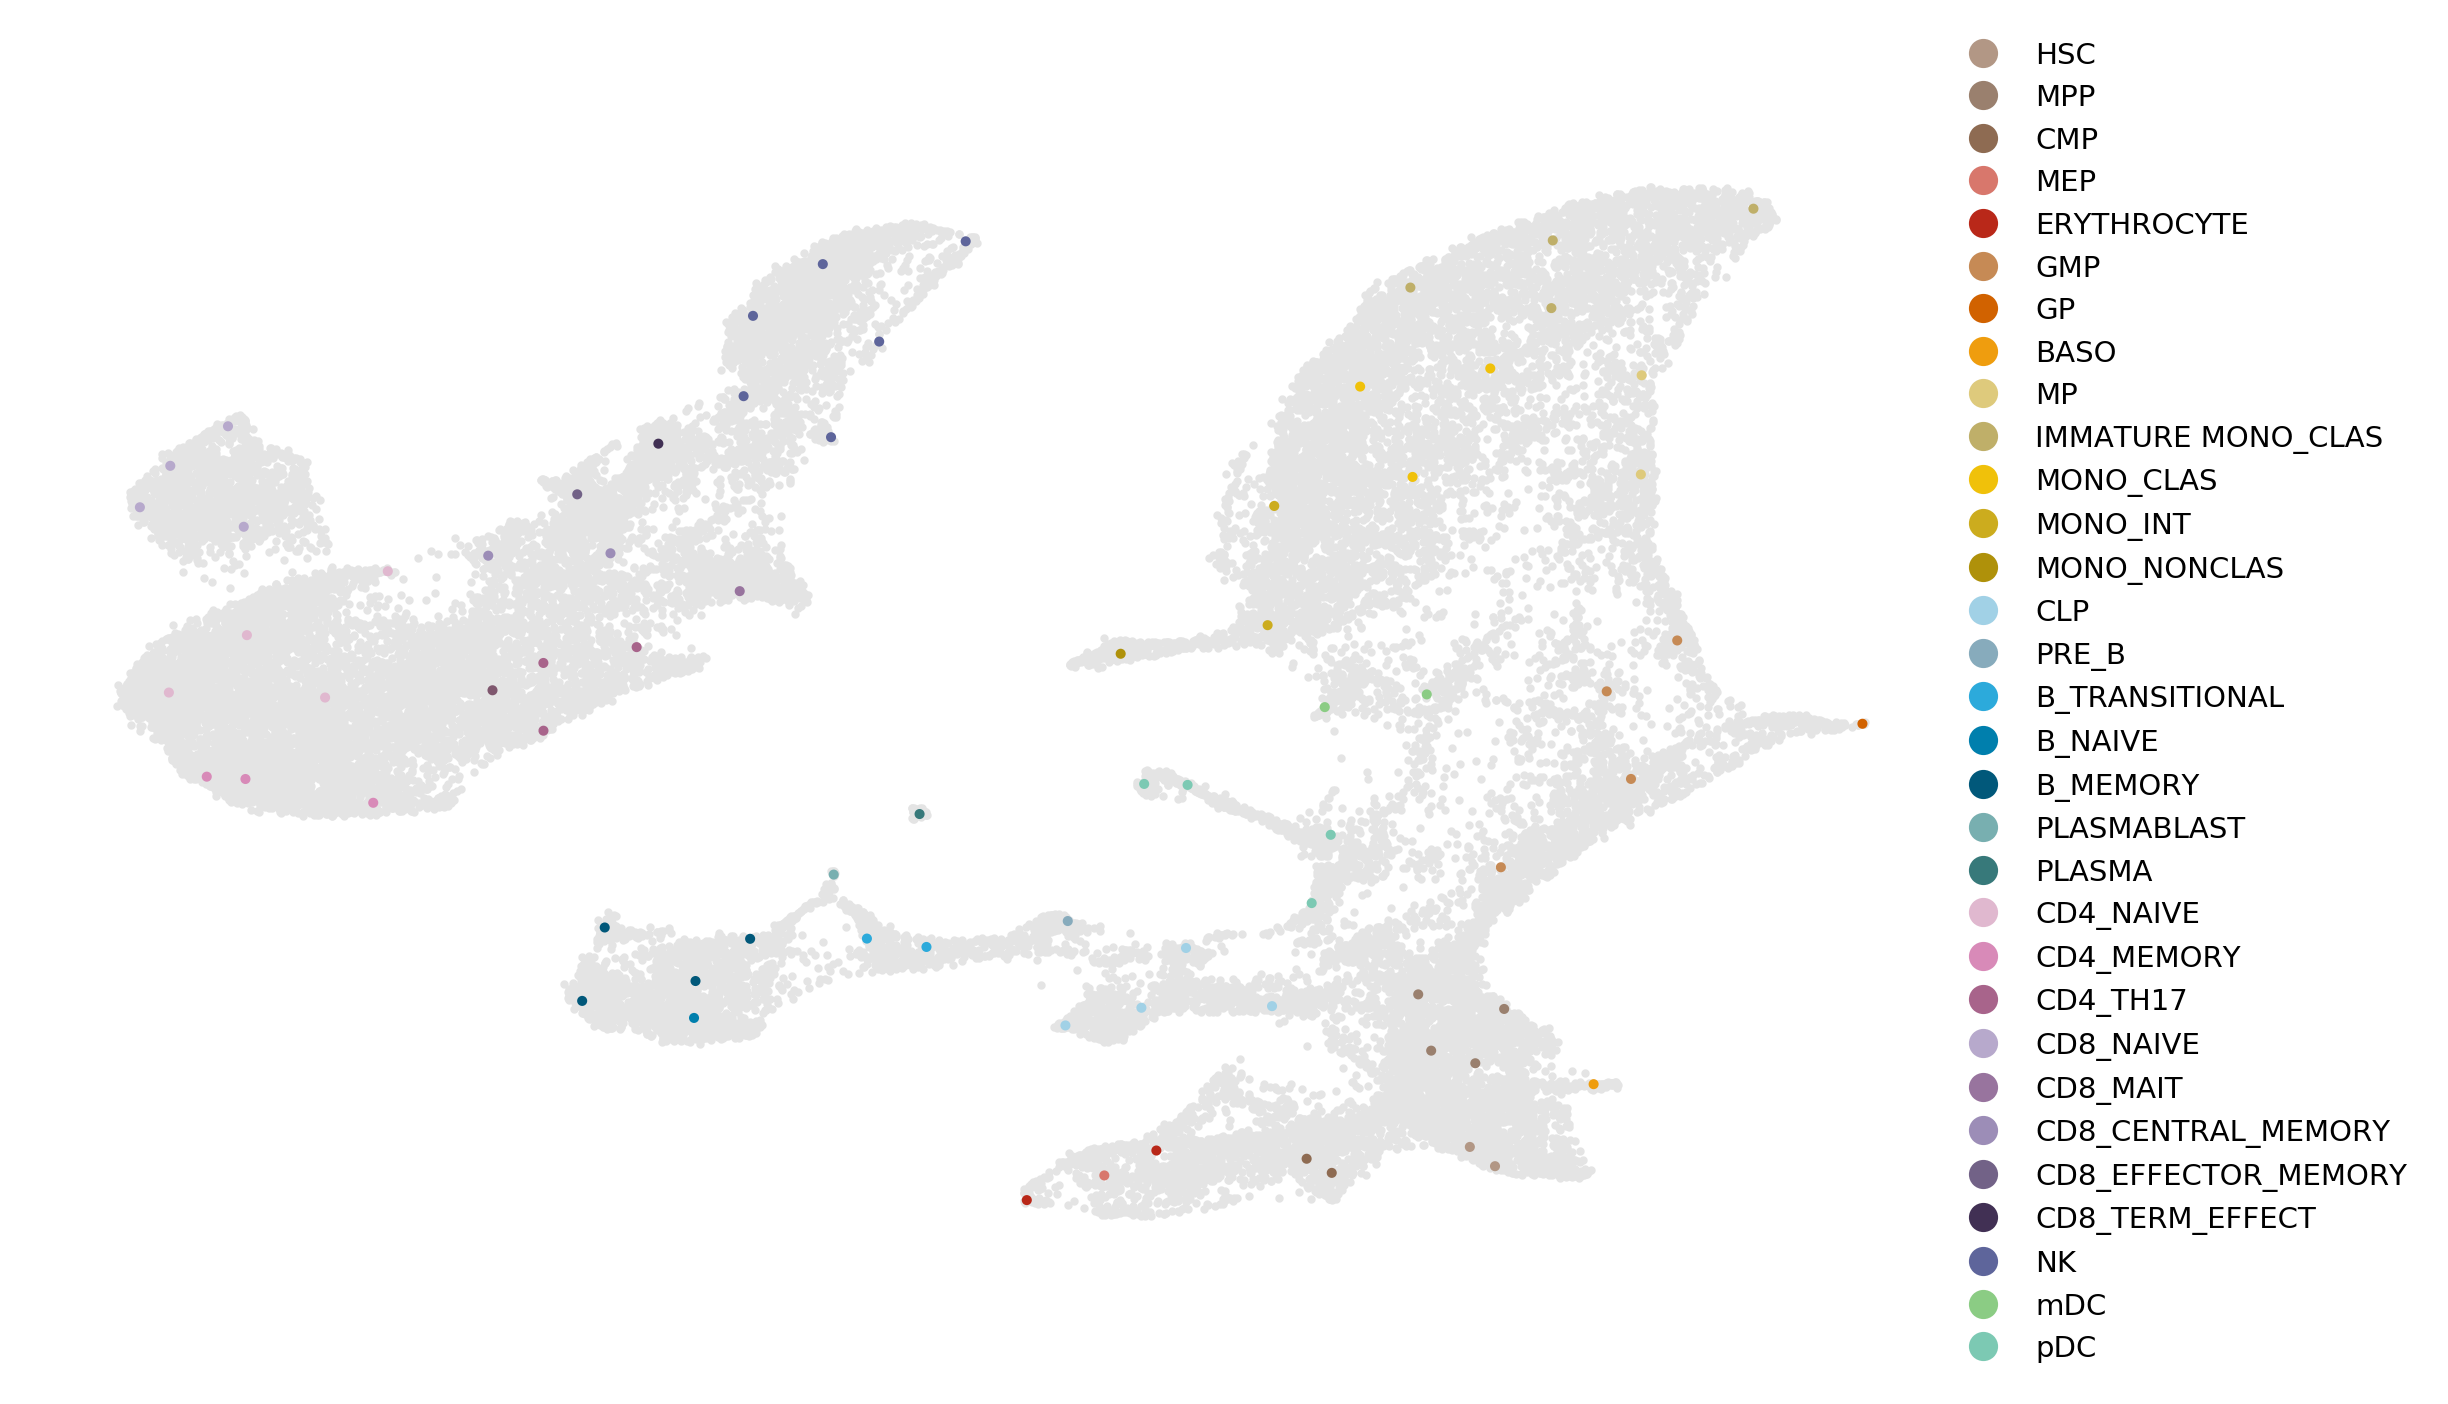

In [16]:
idxsd4000 = np.where(disps.dispersions_norm > 0.6244)[0]
topD4000 = np.array(genes)[idxsd4000]
X_D4000 = X[:, idxsd4000]

TFIDF_D4000 = TFIDF(X_D4000)
SVD_D4000 = TruncatedSVD(n_components=50).fit_transform(TFIDF_D4000)
UMAP_D4000 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_D4000)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_D4000[:, 0], UMAP_D4000[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_D4000[ids, 0], UMAP_D4000[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [17]:
np.save("greenleaf_scRNA_D4000_UMAP.npy", UMAP_D4000)

In [18]:
for k, v in markers.items():
    if v not in topD4000:
        print(f"{v} is not in HVGs")

HBB is not in HVGs
CTSG is not in HVGs


In [19]:
len(set(topE4000).intersection(topD4000)) / 4000

0.348

## 4. Compare using top 2000 genes

In [20]:
s = sig_interval(pscores, n_sds=42.725)
s = sig_dictionary(escores, s)
topE2000 = []
for k, v in s.items():
    topE2000.extend(v)
topE2000 = list(set(topE2000))

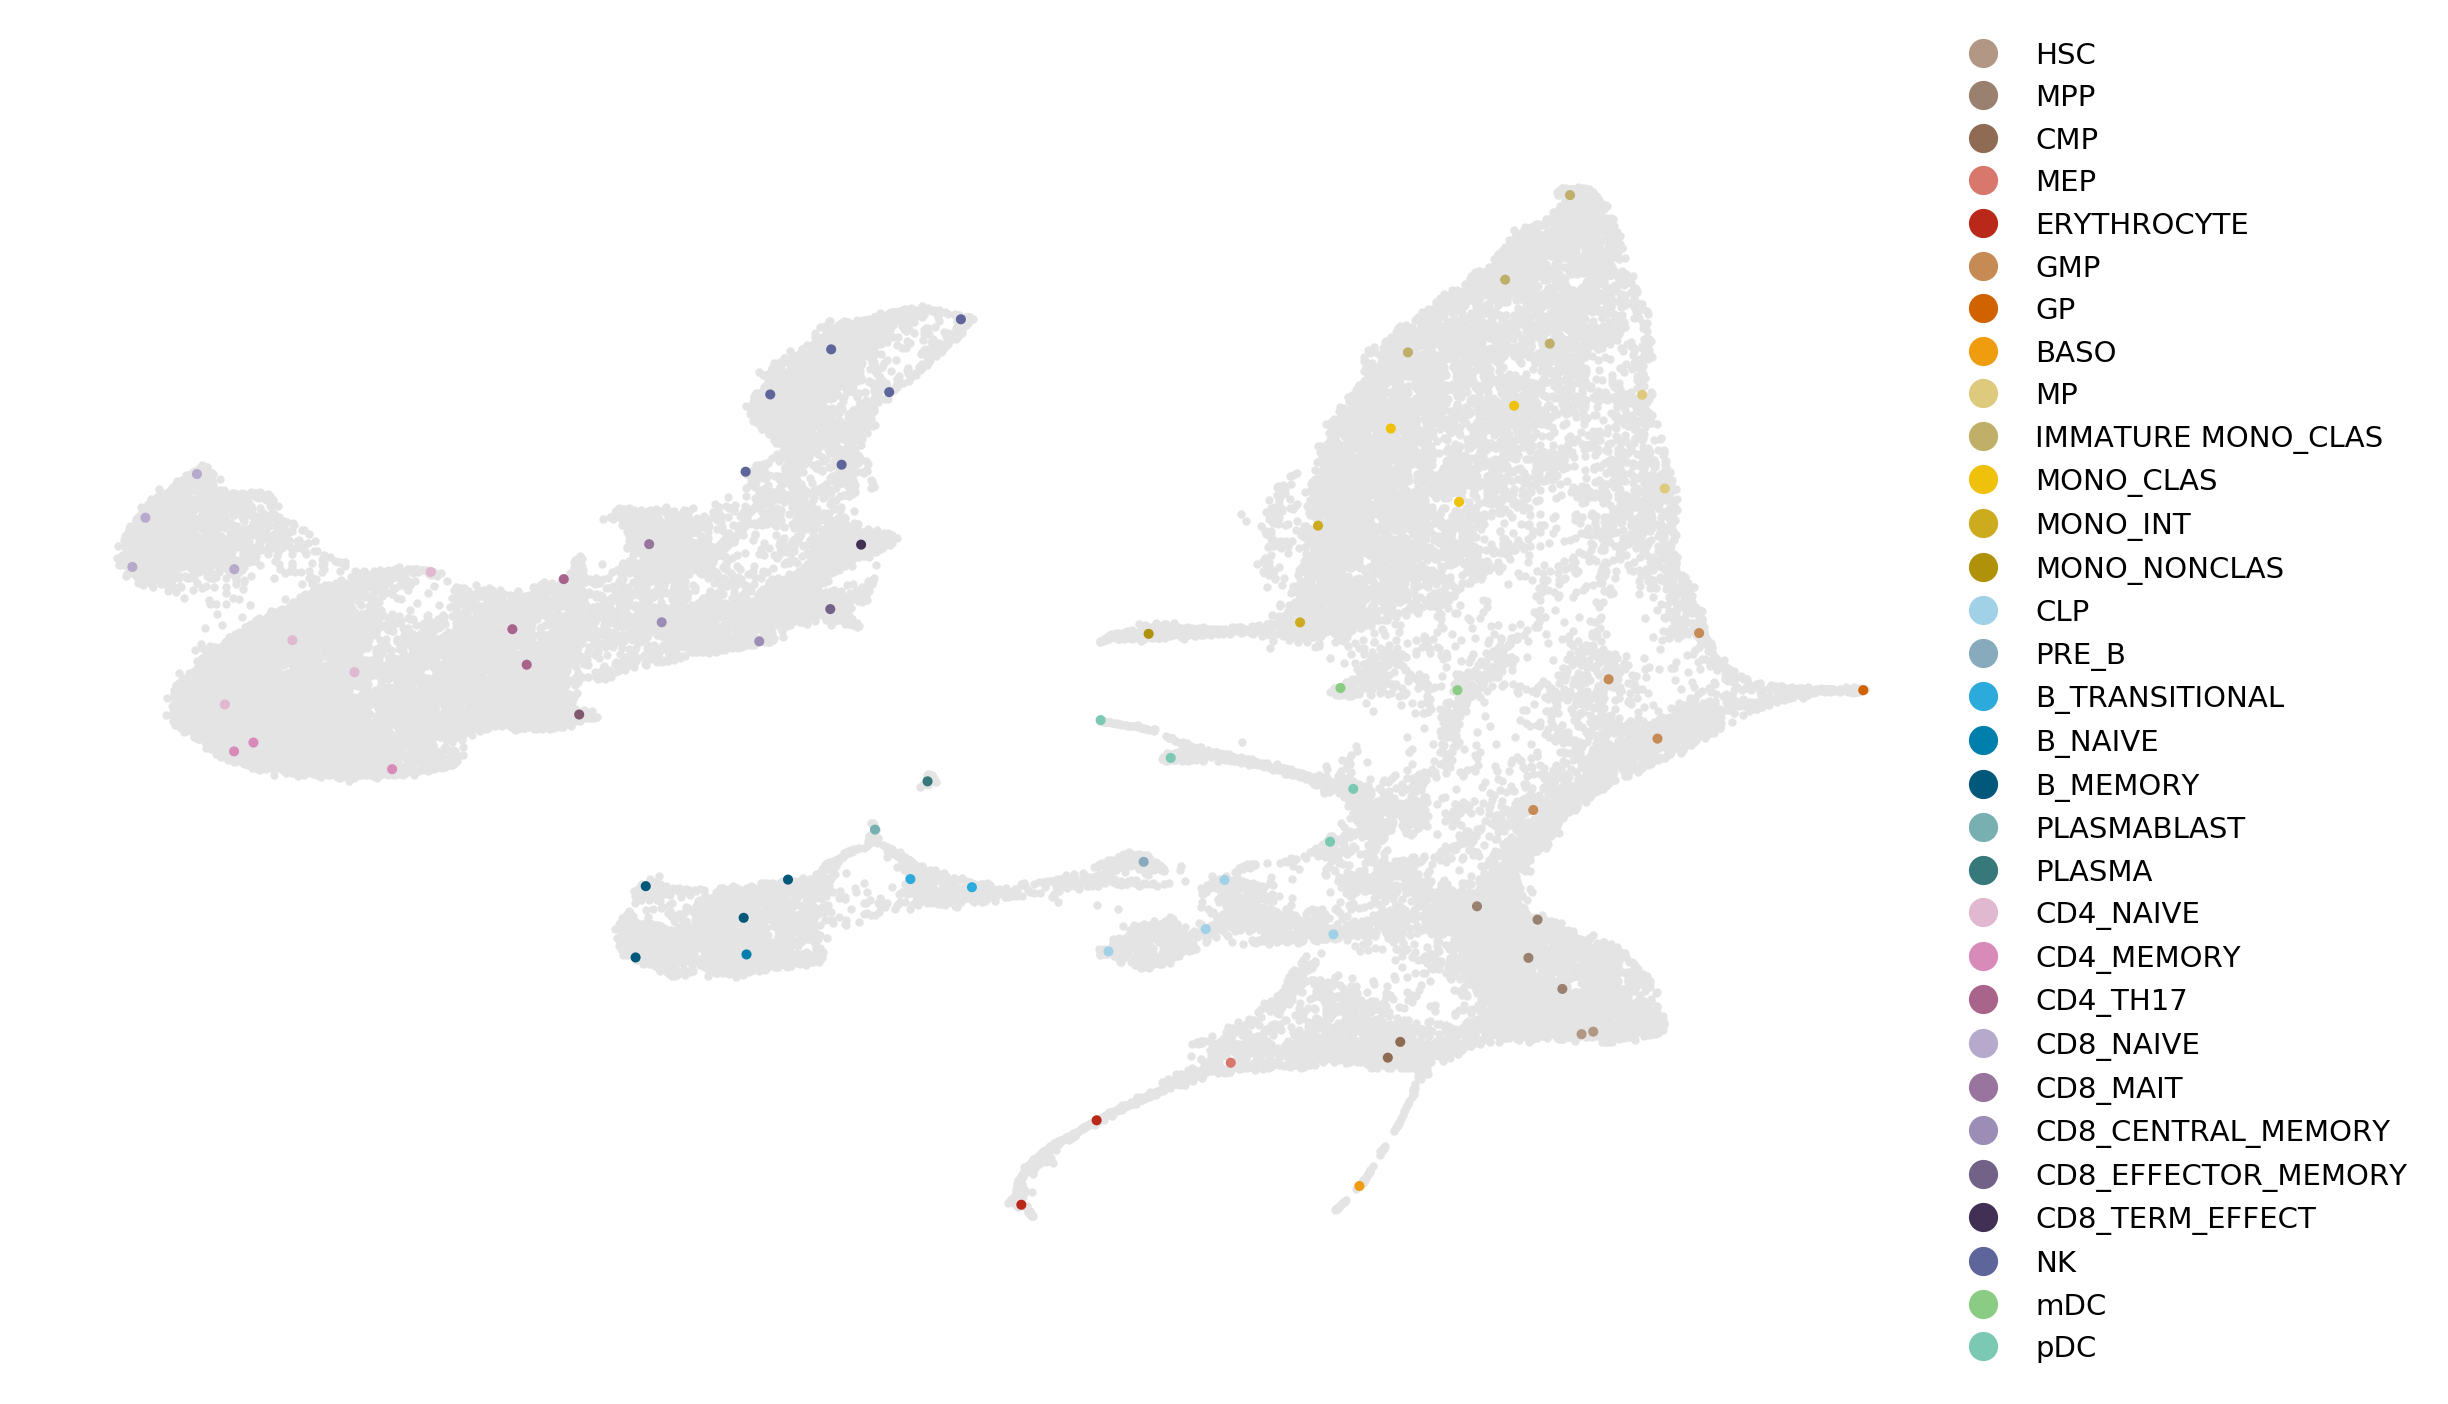

In [21]:
idxsE2000 = np.where(np.isin(genes, topE2000))[0]
X_E2000 = X[:, idxsE2000]

TFIDF_E2000 = TFIDF(X_E2000)
SVD_E2000 = TruncatedSVD(n_components=50).fit_transform(TFIDF_E2000)
UMAP_E2000 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_E2000)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_E2000[:, 0], UMAP_E2000[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_E2000[ids, 0], UMAP_E2000[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [22]:
np.save("greenleaf_scRNA_E2000_UMAP.npy", UMAP_E2000)

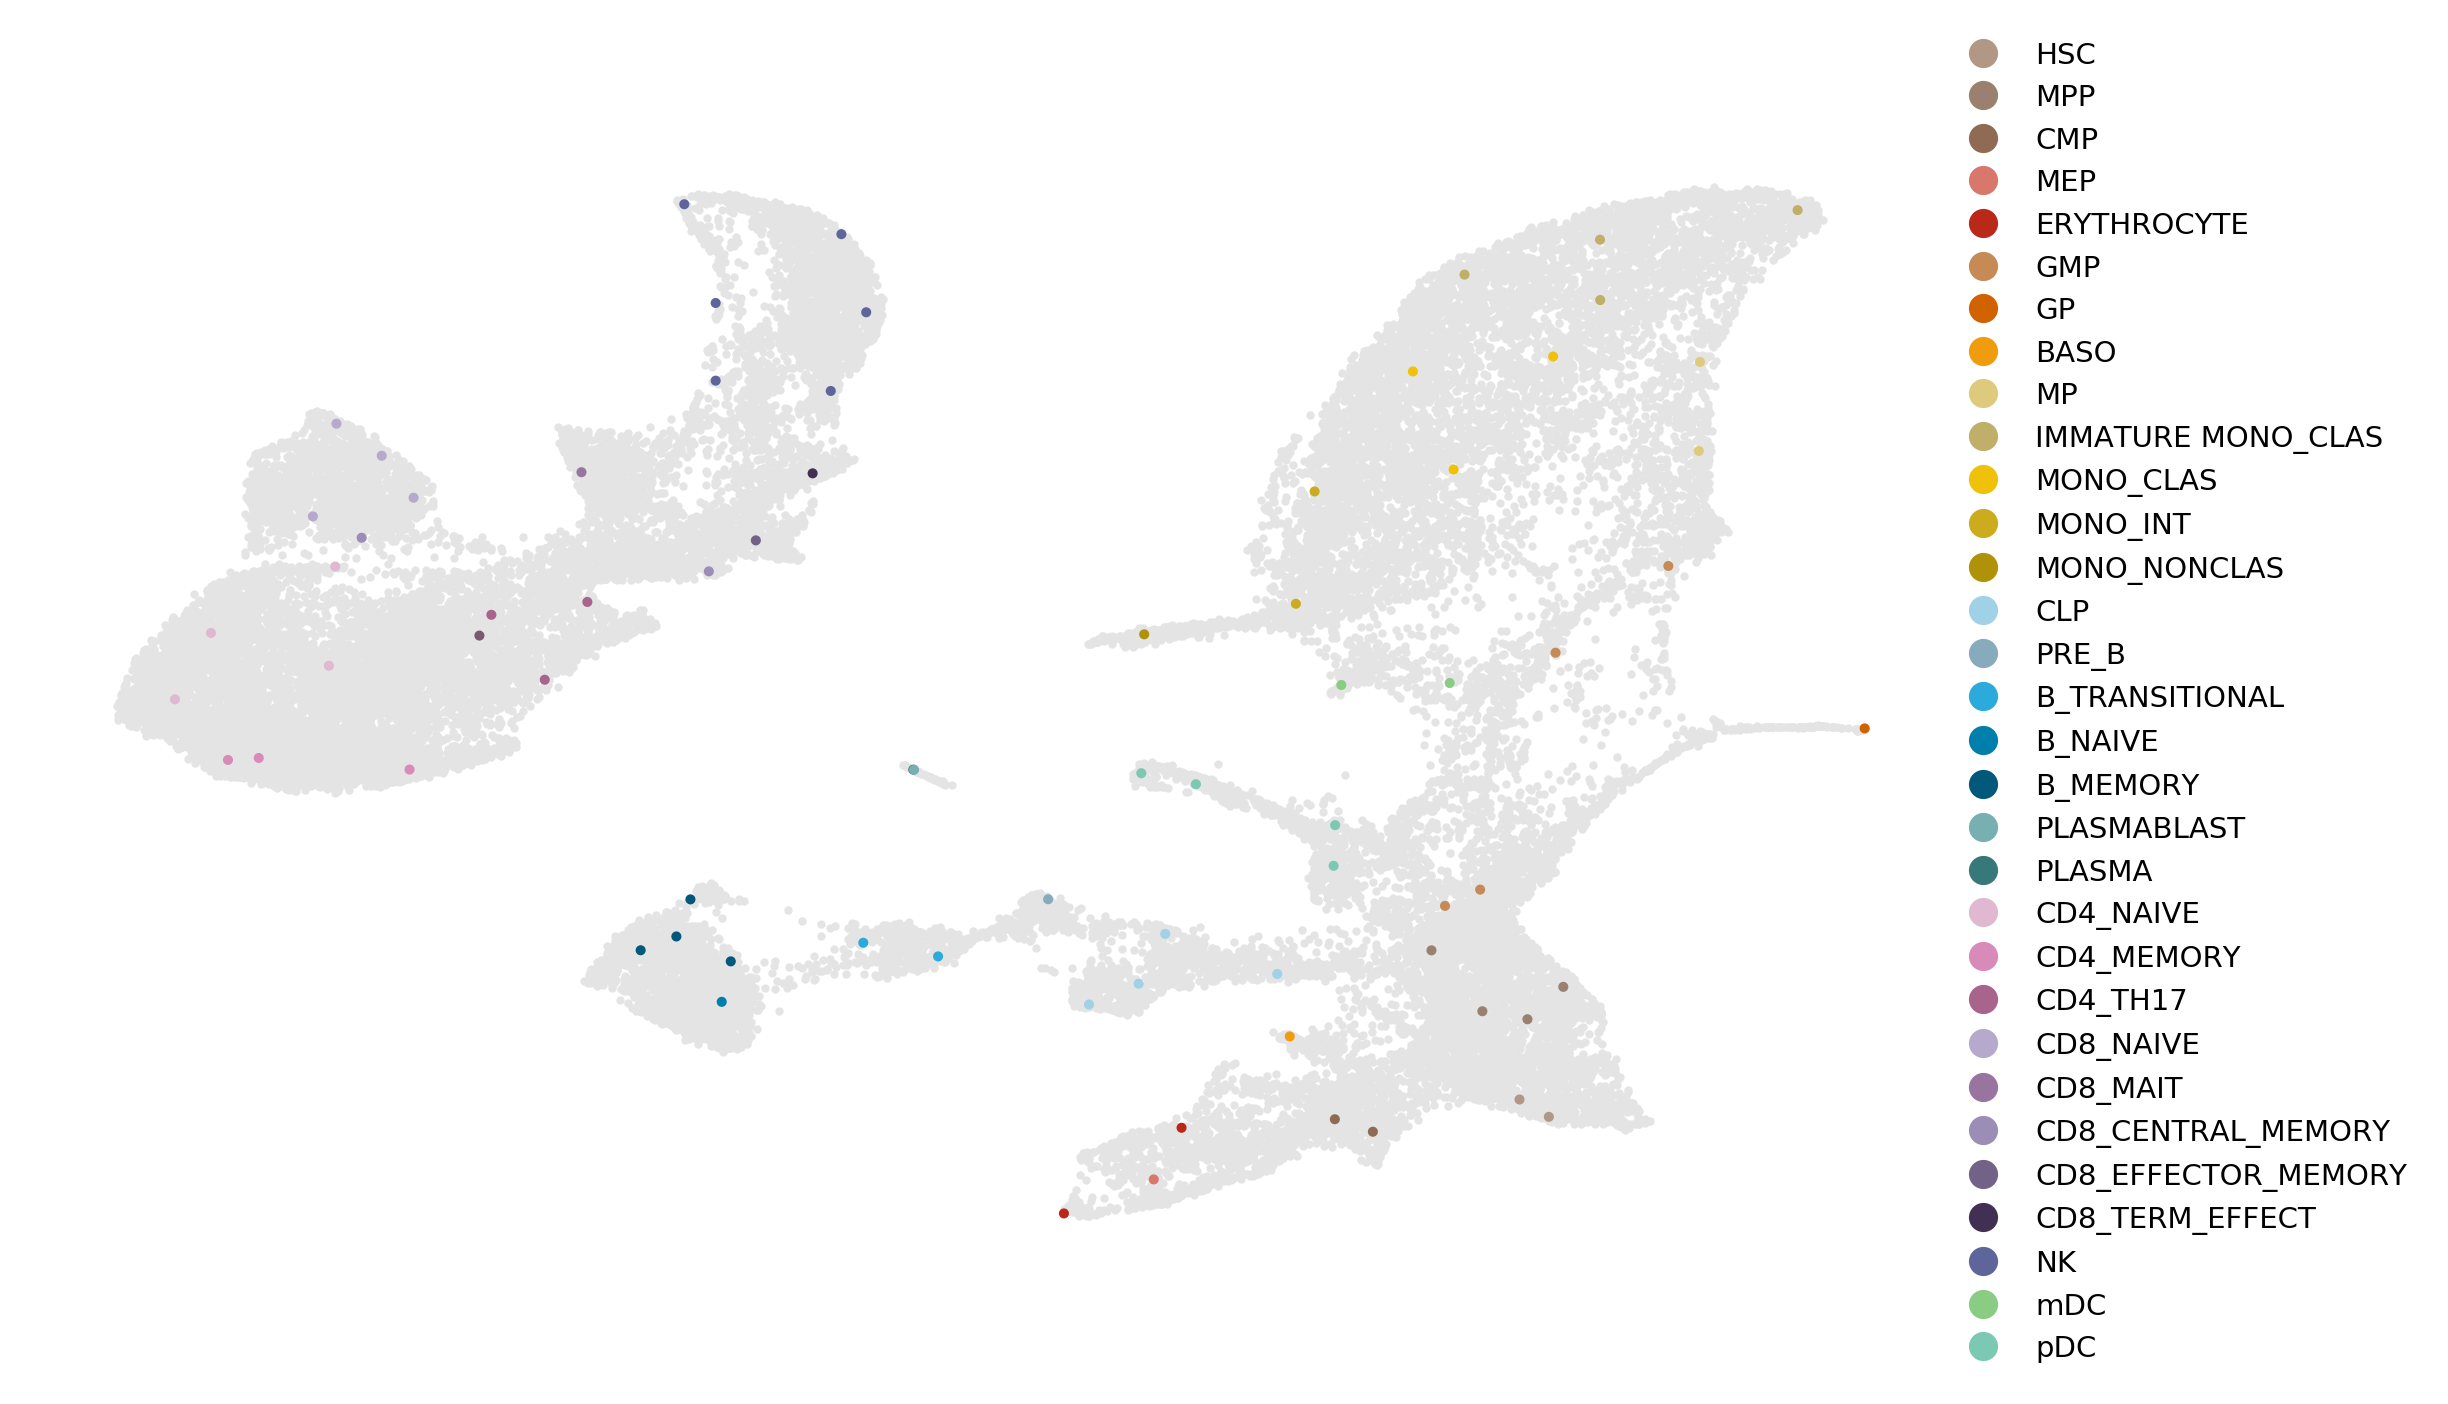

In [23]:
idxsd2000 = np.where(disps.dispersions_norm > 0.99)[0]
topD2000 = np.array(genes)[idxsd2000]
X_D2000 = X[:, idxsd2000]

TFIDF_D2000 = TFIDF(X_D2000)
SVD_D2000 = TruncatedSVD(n_components=50).fit_transform(TFIDF_D2000)
UMAP_D2000 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_D2000)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_D2000[:, 0], UMAP_D2000[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_D2000[ids, 0], UMAP_D2000[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [24]:
np.save("greenleaf_scRNA_D2000_UMAP.npy", UMAP_D2000)

In [25]:
for k, v in markers.items():
    if v not in topD2000:
        print(f"{v} is not in HVGs")

HBB is not in HVGs
MPO is not in HVGs
CTSG is not in HVGs
IGLL5 is not in HVGs
CCL5 is not in HVGs


In [26]:
len(set(topE2000).intersection(topD2000)) / 2000

0.3785

## 5. Compare using the top 1000 genes

In [27]:
s = sig_interval(pscores, n_sds=60.53)
s = sig_dictionary(escores, s)
topE1000 = []
for k, v in s.items():
    topE1000.extend(v)
topE1000 = list(set(topE1000))
print(len(topE1000))

1000


In [28]:
idxsE1000 = np.where(np.isin(genes, topE1000))[0]
X_E1000 = X[:, idxsE1000]

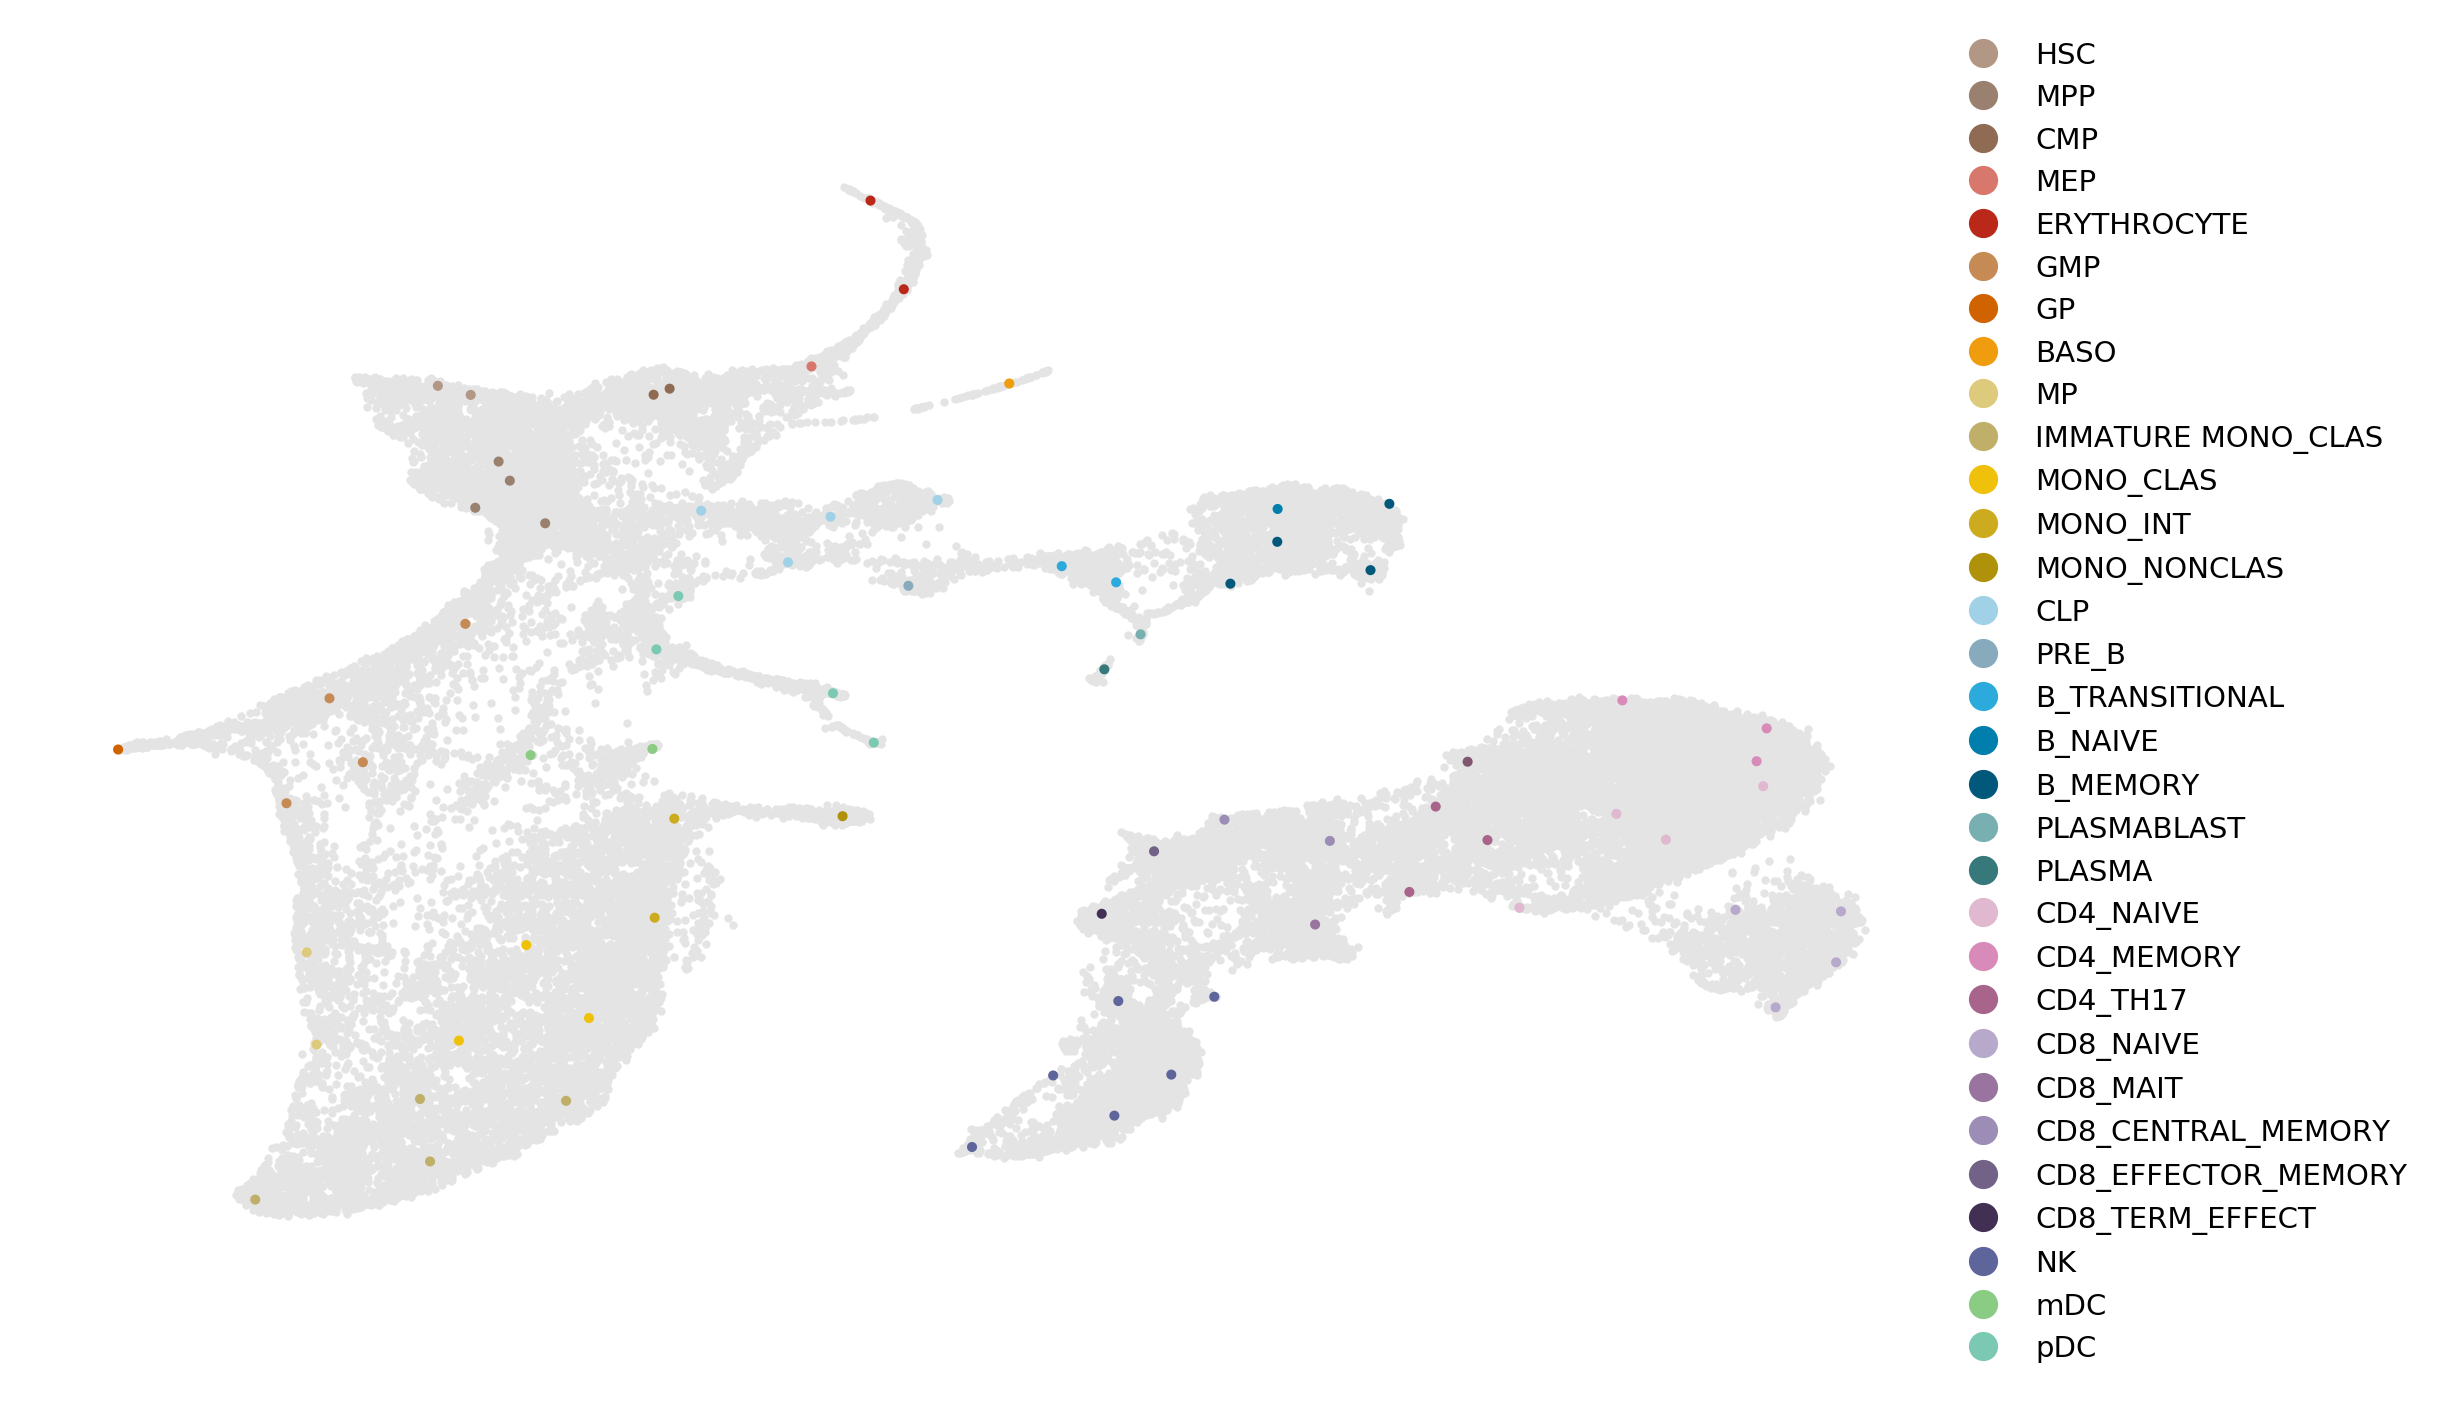

In [29]:
TFIDF_E1000 = TFIDF(X_E1000)
SVD_E1000 = TruncatedSVD(n_components=50).fit_transform(TFIDF_E1000)
UMAP_E1000 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_E1000)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_E1000[:, 0], UMAP_E1000[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_E1000[ids, 0], UMAP_E1000[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [30]:
np.save("greenleaf_scRNA_E1000_UMAP.npy", UMAP_E1000)

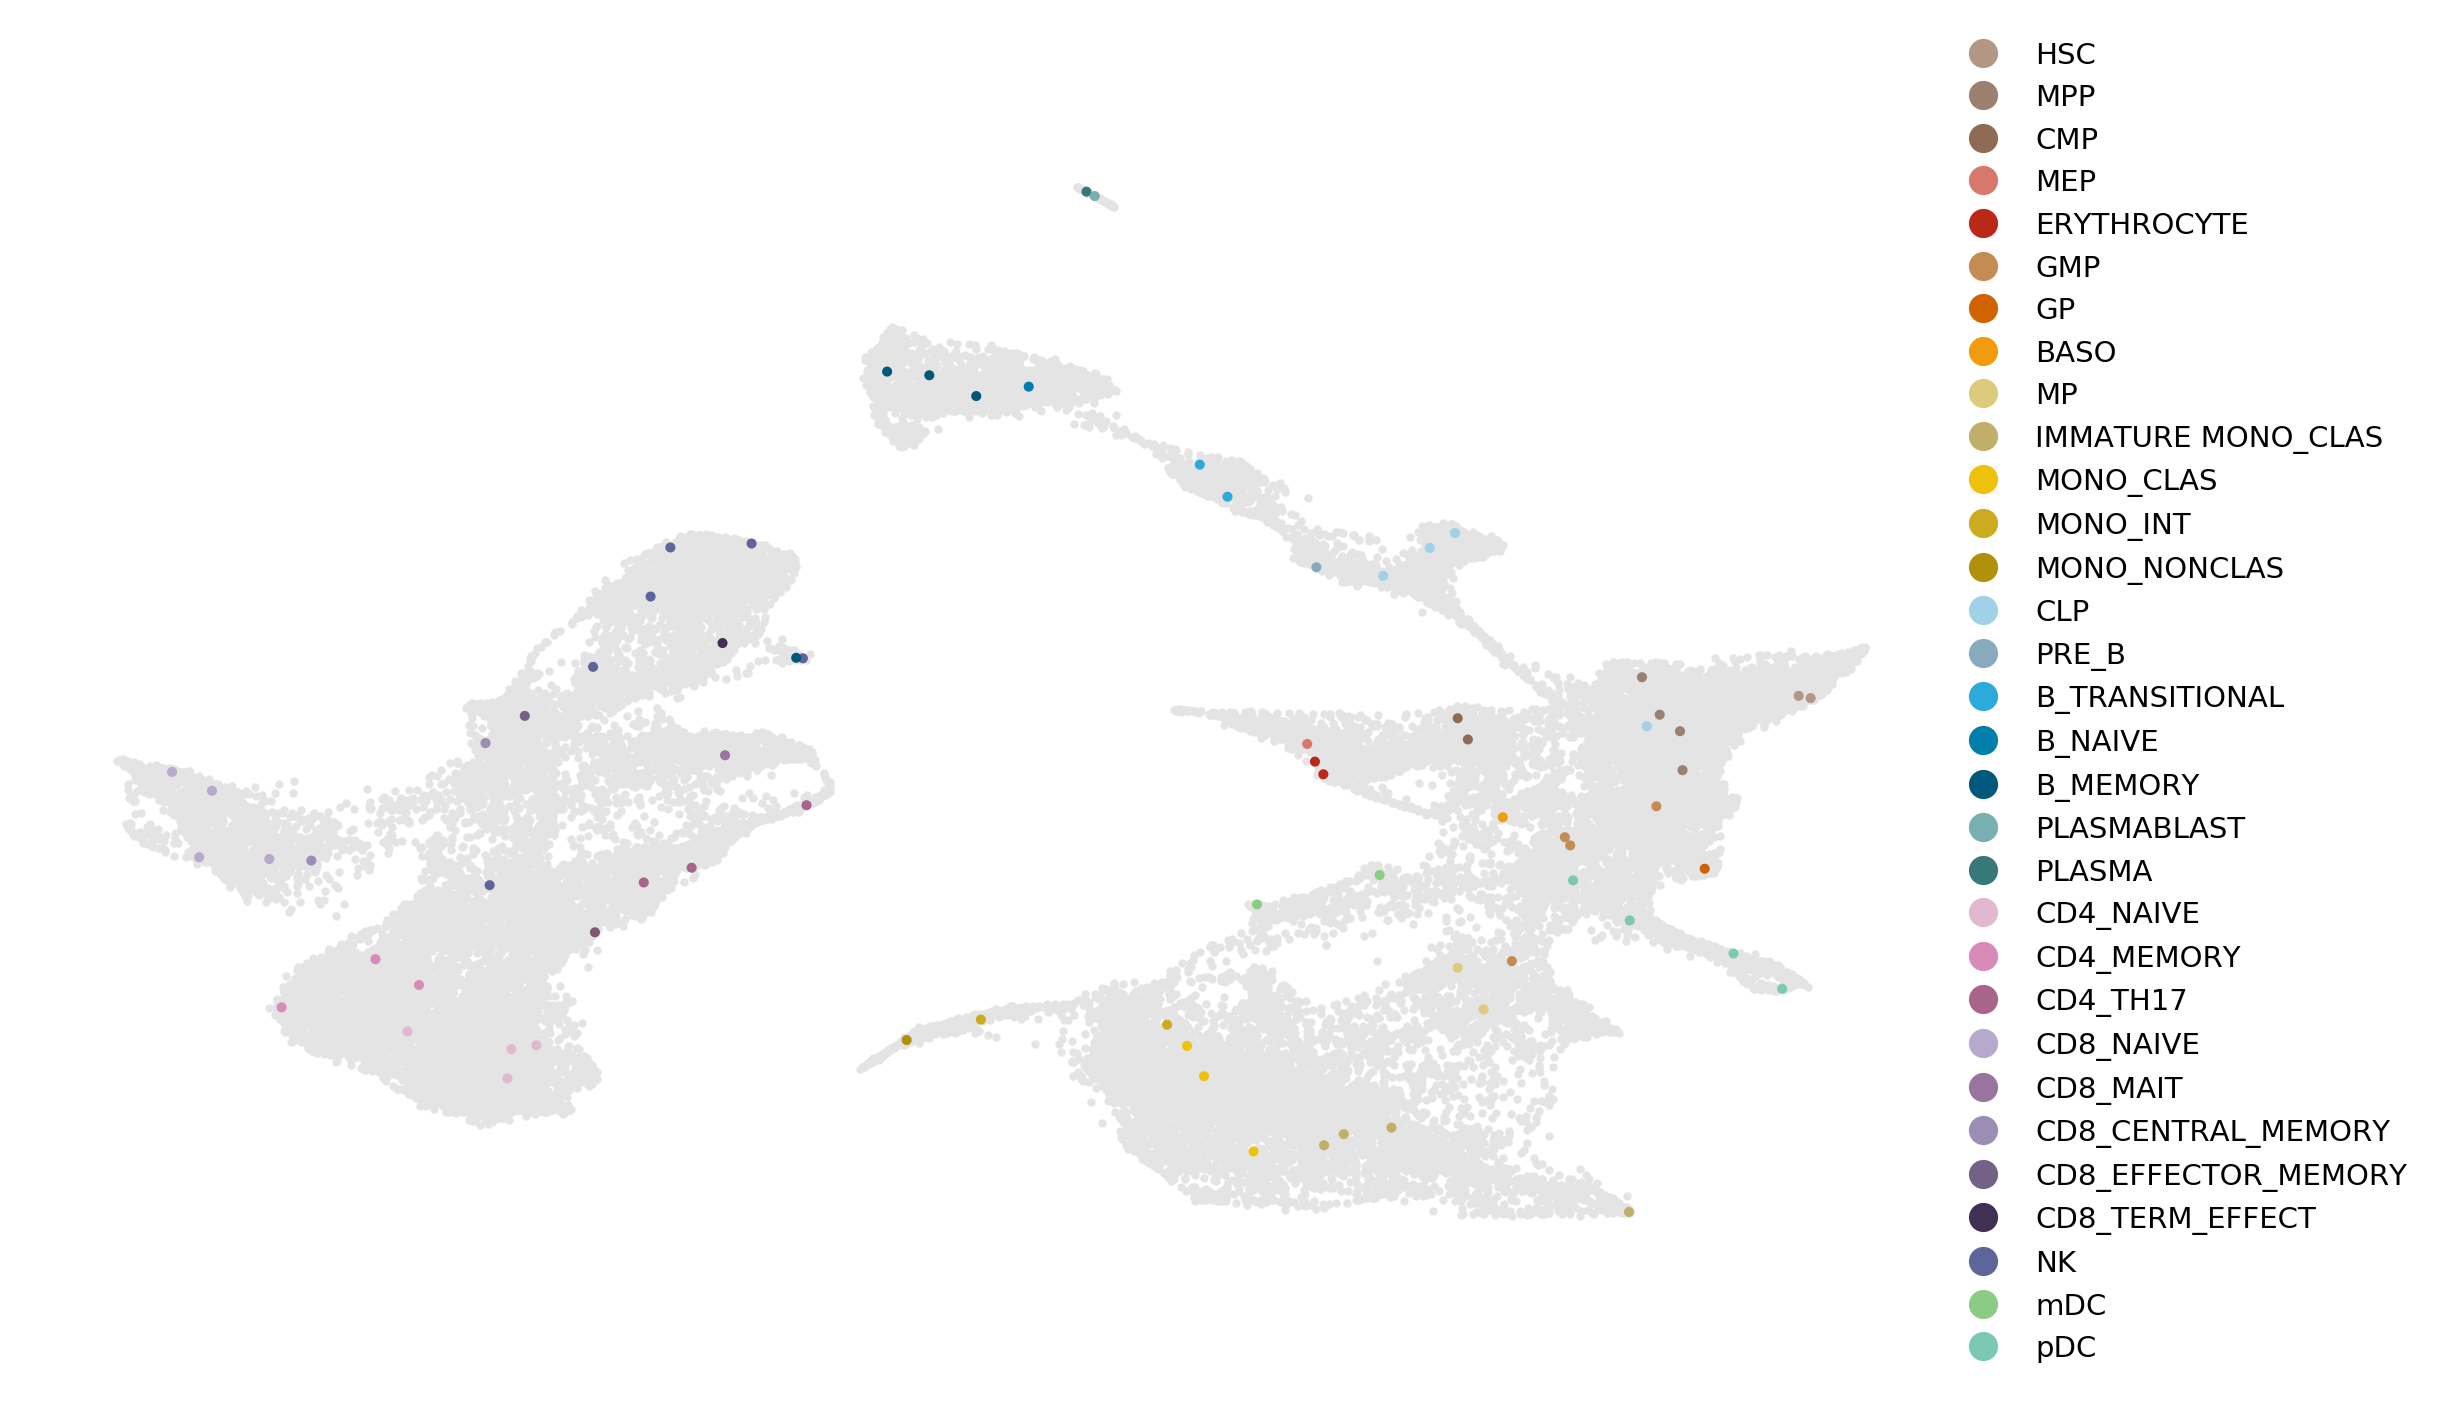

In [31]:
idxsd1000 = np.where(disps.dispersions_norm > 1.4066)[0]
topD1000 = np.array(genes)[idxsd1000]
X_D1000 = X[:, idxsd1000]

TFIDF_D1000 = TFIDF(X_D1000)
SVD_D1000 = TruncatedSVD(n_components=50).fit_transform(TFIDF_D1000)
UMAP_D1000 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_D1000)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_D1000[:, 0], UMAP_D1000[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_D1000[ids, 0], UMAP_D1000[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [32]:
np.save("greenleaf_scRNA_D1000_UMAP.npy", UMAP_D1000)

In [33]:
for k, v in markers.items():
    if v not in topD1000:
        print(f"{v} is not in HVGs")

HBB is not in HVGs
MPO is not in HVGs
CTSG is not in HVGs
S100A9 is not in HVGs
VCAN is not in HVGs
IGLL5 is not in HVGs
LTB is not in HVGs
CCL5 is not in HVGs
GNLY is not in HVGs
ENHO is not in HVGs


In [34]:
len(set(topE1000).intersection(topD1000)) / 1000

0.364

## 6. Compare using the top 500 genes

In [35]:
s = sig_interval(pscores, n_sds=80.5)
s = sig_dictionary(escores, s)
topE500 = []
for k, v in s.items():
    topE500.extend(v)
topE500 = list(set(topE500))
print(len(topE500))

500


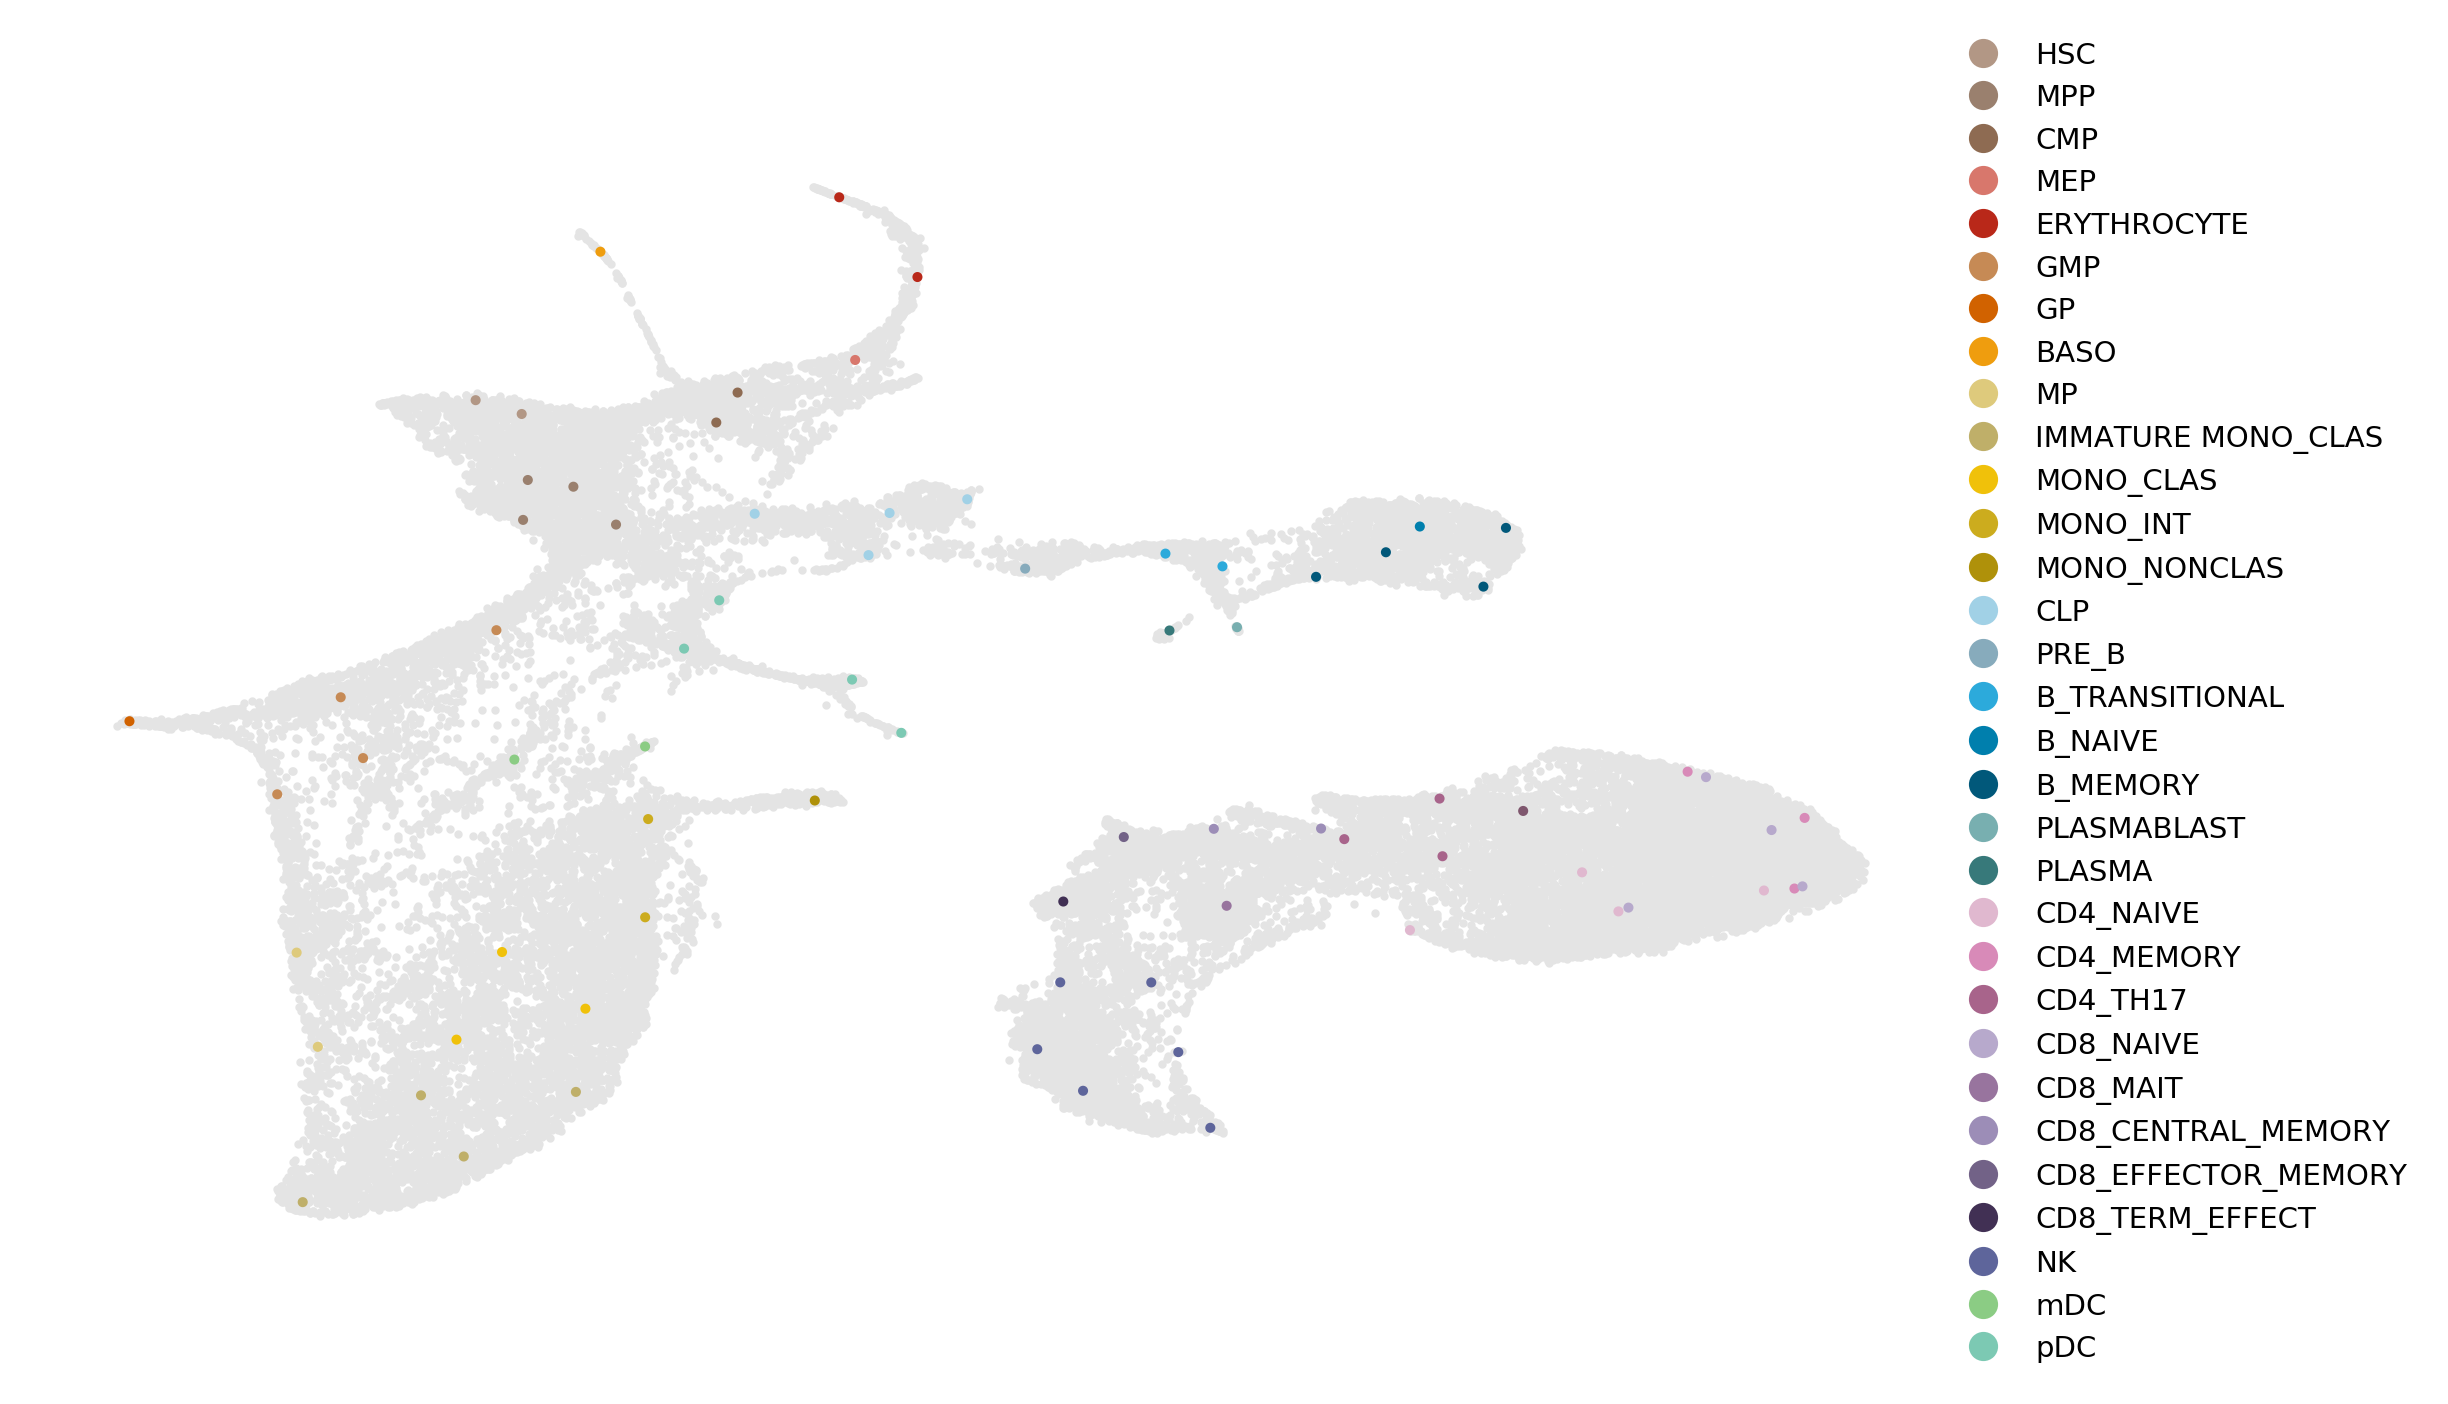

In [36]:
idxsE500 = np.where(np.isin(genes, topE500))[0]
X_E500 = X[:, idxsE500]

TFIDF_E500 = TFIDF(X_E500)
SVD_E500 = TruncatedSVD(n_components=50).fit_transform(TFIDF_E500)
UMAP_E500 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_E500)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_E500[:, 0], UMAP_E500[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_E500[ids, 0], UMAP_E500[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [37]:
np.save("greenleaf_scRNA_E500_UMAP.npy", UMAP_E500)

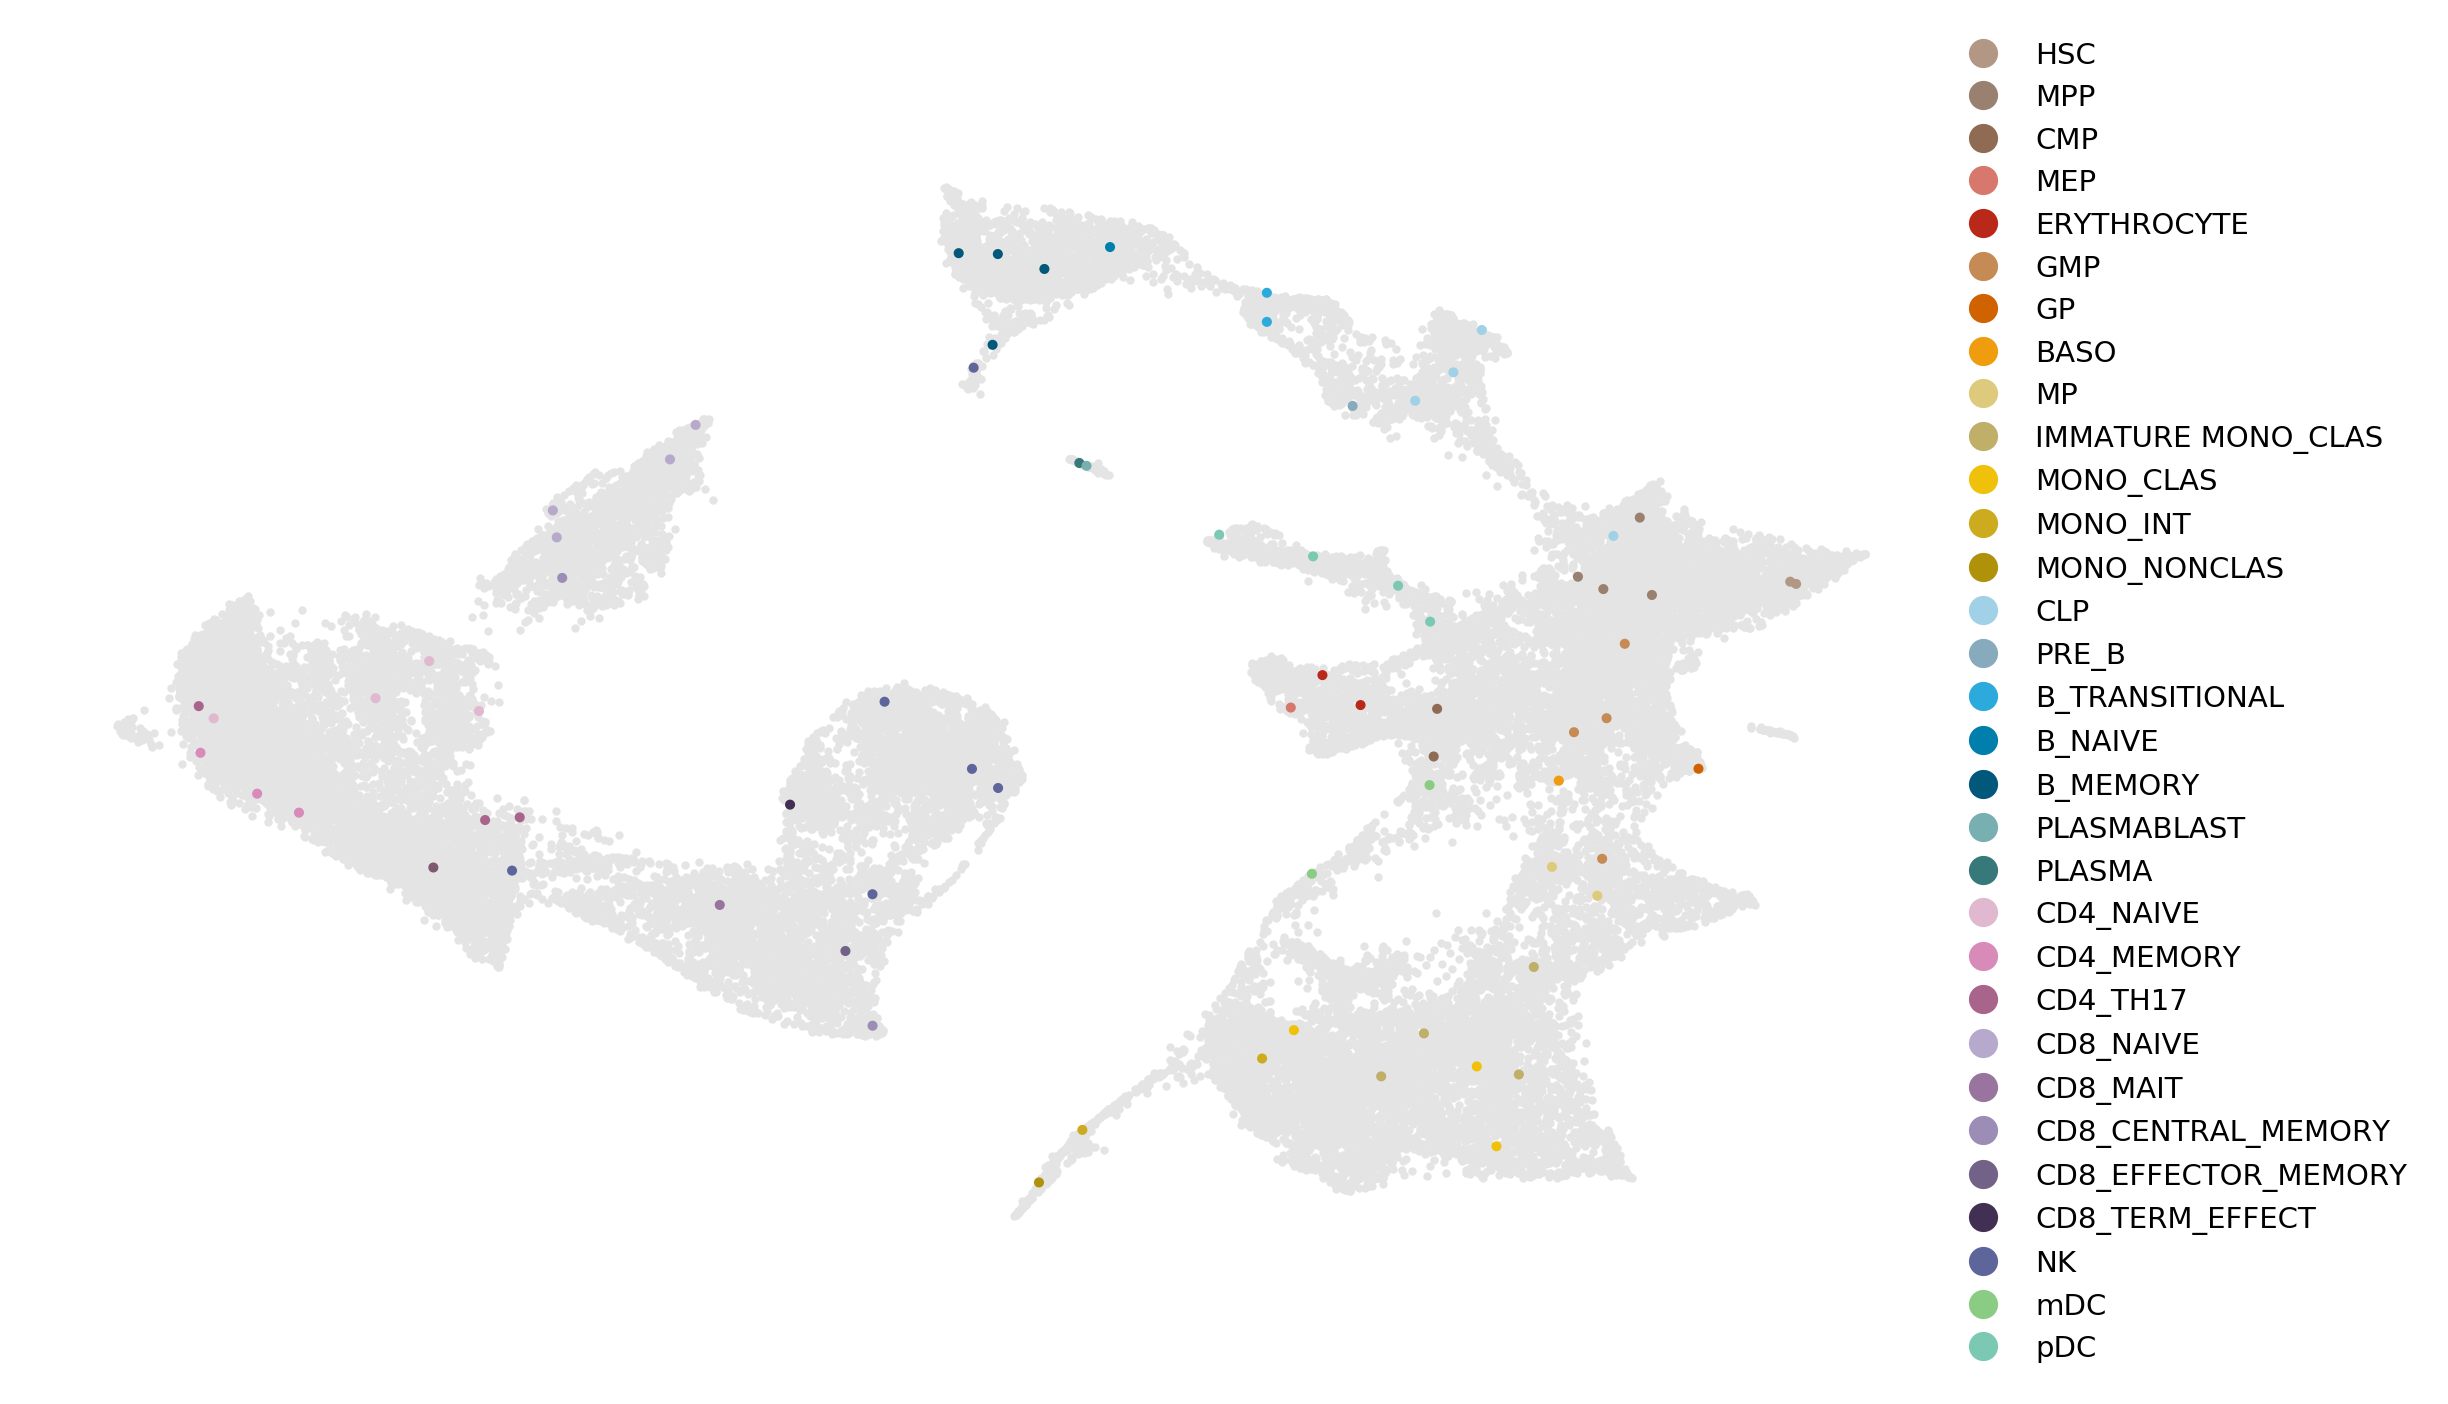

In [38]:
idxsd500 = np.where(disps.dispersions_norm > 1.89)[0]
topD500 = np.array(genes)[idxsd500]
X_D500 = X[:, idxsd500]

TFIDF_D500 = TFIDF(X_D500)
SVD_D500 = TruncatedSVD(n_components=50).fit_transform(TFIDF_D500)
UMAP_D500 = UMAP(n_components=2, n_neighbors=30,
                  min_dist=0.3, random_state=42).fit_transform(SVD_D500)

plt.figure(figsize=(8.27, 5), dpi=300)
plt.scatter(UMAP_D500[:, 0], UMAP_D500[:, 1], color="#e4e4e4", s=1)
plt.scatter(UMAP_D500[ids, 0], UMAP_D500[ids, 1], c=colors, s=2)
ax = plt.gca()
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.set_frame_on(False)
leg = plt.legend(marker, legend.keys(), numpoints=1, fontsize=7, ncol=1,
                 loc="center right", bbox_to_anchor=(1.25, 0.5))
leg.get_frame().set_linewidth(0.0)

In [39]:
np.save("greenleaf_scRNA_D500_UMAP.npy", UMAP_D500)

In [40]:
for k, v in markers.items():
    if v not in topD500:
        print(f"{v} is not in HVGs")

HBB is not in HVGs
MPO is not in HVGs
CTSG is not in HVGs
S100A9 is not in HVGs
VCAN is not in HVGs
C1QA is not in HVGs
IGLL5 is not in HVGs
TNFRSF17 is not in HVGs
LTB is not in HVGs
DUSP4 is not in HVGs
CCL5 is not in HVGs
DUSP2 is not in HVGs
NKG7 is not in HVGs
GNLY is not in HVGs
ENHO is not in HVGs
